# Comparing Clustering Algorithms

There are a lot of clustering algorithms available and choosing the right one is sometimes difficult. As most of the time in data science it depends on your data which algorithm is suitable. If you don't know much about the data (yet) it might be difficult to choose the right clustering algorithm for your case. 

In this notebook we will use an artificially generated dataset to compare several clustering algorithms. We will visualize the results of the algorithms to evaluate their statistical performance and also compare the run times of these algorithms.

At the end of this notebook you should: 
* know how to use the sklearn implementations of `KMeans`, `AgglomerativeClustering`, and `DBSCAN`
* know which hyperparamter you can use to adjust the algorithm
* have a rough overview of the advantages and disadvantages of the algorithms

## Import and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import time
import scipy.cluster.hierarchy as sch
from sklearn.neighbors import NearestNeighbors

# Specifying figure layout
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_color_codes('bright')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.rcParams["figure.figsize"] = (15, 10)

In order to compare different clustering algorithms we'll need some data. Since most of the time real-world data has more than two features/dimensions it's just not possible to visualize it. For our comparison we will therefore use an artificial created dataset with some non-globular clusters and noise. 

In [3]:
# Load data
data = np.load('data/cluster_data.npy')
data.shape

(2309, 2)

Let's have a look at the data.

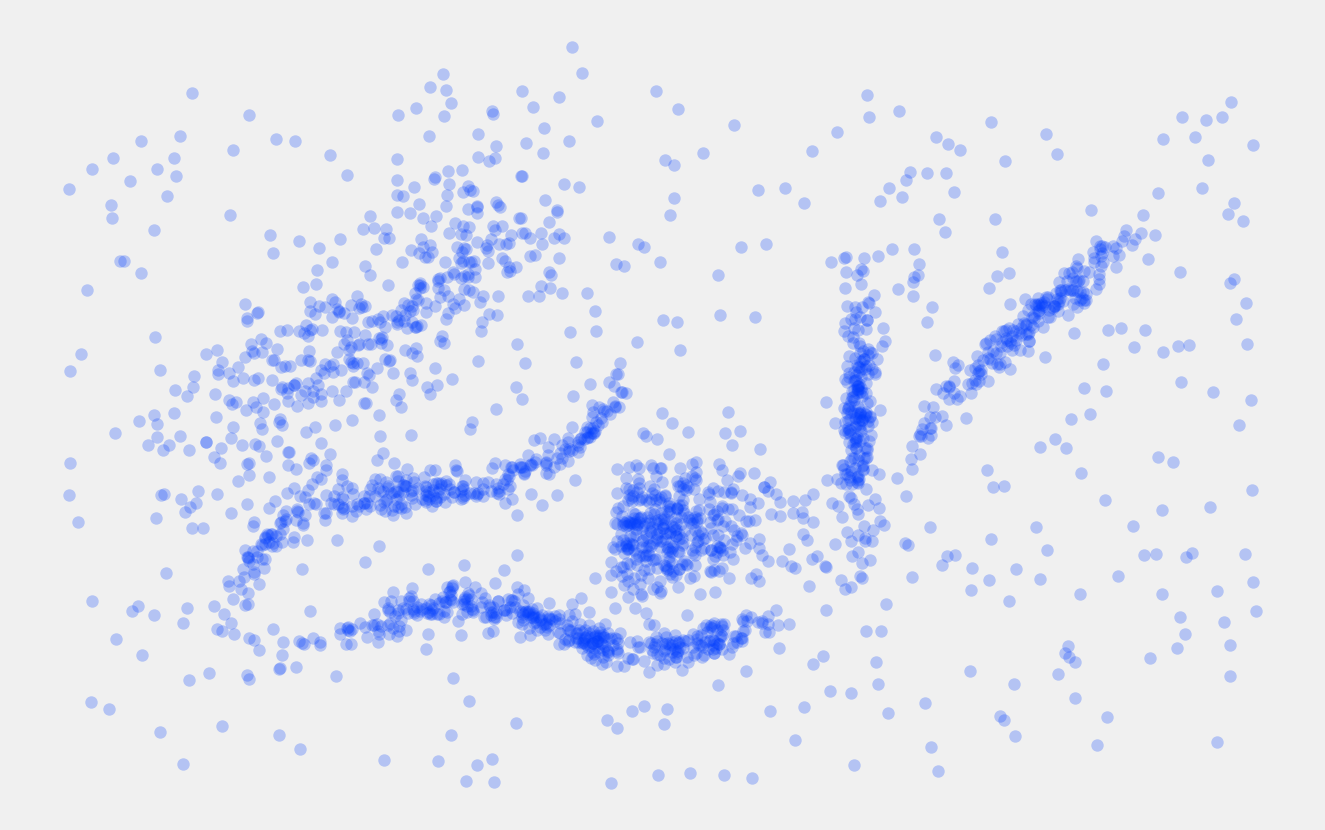

In [4]:
# Visualizing the data
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

We can definitely identify some clusters even if the data is quite noisy in some parts. To make things more interesting some clusters are clearly elongated and drawing clear boundaries is difficult. Let's see how the different algorithms will perform when clustering the data. 

## Testing the Algorithms

Hopefully you remember the acronym DRY. We don't want to write the same code for testing the different algorithms over and over again. Therefore we'll define a utility function that does the clustering and takes the time the algorithm needs as well as visualizes the result.

We need to keep in mind that in real use cases we usually **cannot** look at the data to see if some of the points were assigned to a wrong cluster.

In [5]:
# defining a utility function for testing the clustering algorithms
def plot_clusters(data, algorithm, kwds):
    # cluster the data while taking the time the process needs 
    start_time = time.time()
    labels = algorithm(**kwds).fit_predict(data)
    end_time = time.time()
    
    # defining the colors for visual representation
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    # plotting the data, removing the axis and adding title and time 
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

## K-Means

K-Means is probably the most common clustering algorithm. It is fast, easy to understand and you will find an implementation in most of the statistical or machine learning tools you will come across to use at some point.


### How does it work?

The objective of K-Means is simple: group similar data points together to a fixed number (*k*) of clusters. Besides the data the only thing the algorithm needs as an input is the number of clusters *k*. *K* in this case can also be seen as the number of centroids, with a centroid being the imaginary or real location representing the cluster center.

The algorithm aims to choose centroids that minimize the **inertia**, or **within-cluster sum of squared criterion**:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

It starts with an initial estimate of the centroid locations. The algorithm then iterates between two steps: 

#### 1. Data assignment

Each centroid defines one of the clusters. In this step, each data point is assigned to its nearest centroid, based on the squared Euclidean distance. More formally, if $c_i$ is the collection of centroids in set $C$, then each data point $x$ is assigned to a cluster based on

$$\underset{c_i \in C}{\arg\min} \; dist(c_i,x)^2$$


where dist( · ) is the standard ($L_2$) Euclidean distance. Let the set of data point assignments for each ith cluster centroid be $S_i$.


#### 2. Centroid update       

In this step, the centroids are recomputed. This is done by taking the mean of all data points assigned to that centroid's cluster.

$$c_j=\frac{1}{|S_j|}\sum_{x_i \in S_j} x_i$$

The difference between the old and new centroids are computed and the algorithm repeats the two steps until a stopping criteria is met (i.e., the value is less than a threshold, no data points change clusters, the sum of the distances is minimized, or some maximum number of iterations is reached).


#### Convergence and random initialization

Given enough time this algorithm is guaranteed to converge to a result. The result may be a local minimum (i.e. not necessarily the best possible outcome), meaning that assessing more than one run of the algorithm with randomized starting centroids may give a better outcome.


<img src=https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif style="width: 500px;" />

### Pros and Cons

#### Limitations

* Algorithm has problems identifying elongated clusters or irregular shapes. 
* We need to specify how many clusters we expect. If we don't know which number might be reasonable we have to run the algorithm several times with different *k* values and evaluate each run using for example the variation on intra-cluster vs. inter-cluster distance to find the optimal value for *k*.  

#### Advantages

* K-Means can be exceptionally efficient. This is K-Means big win. It's a simple algorithm and with the right tricks and optimizations there are few algorithms that can compete with K-Means for performance. If you have truly huge data then K-Means might be your only option.


Let's see how the algorithm performs with our data.

c:\Users\email\Desktop\neuefische\DS_Neuefisch\250200_DS_Neuefisch\0318_Clustering\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


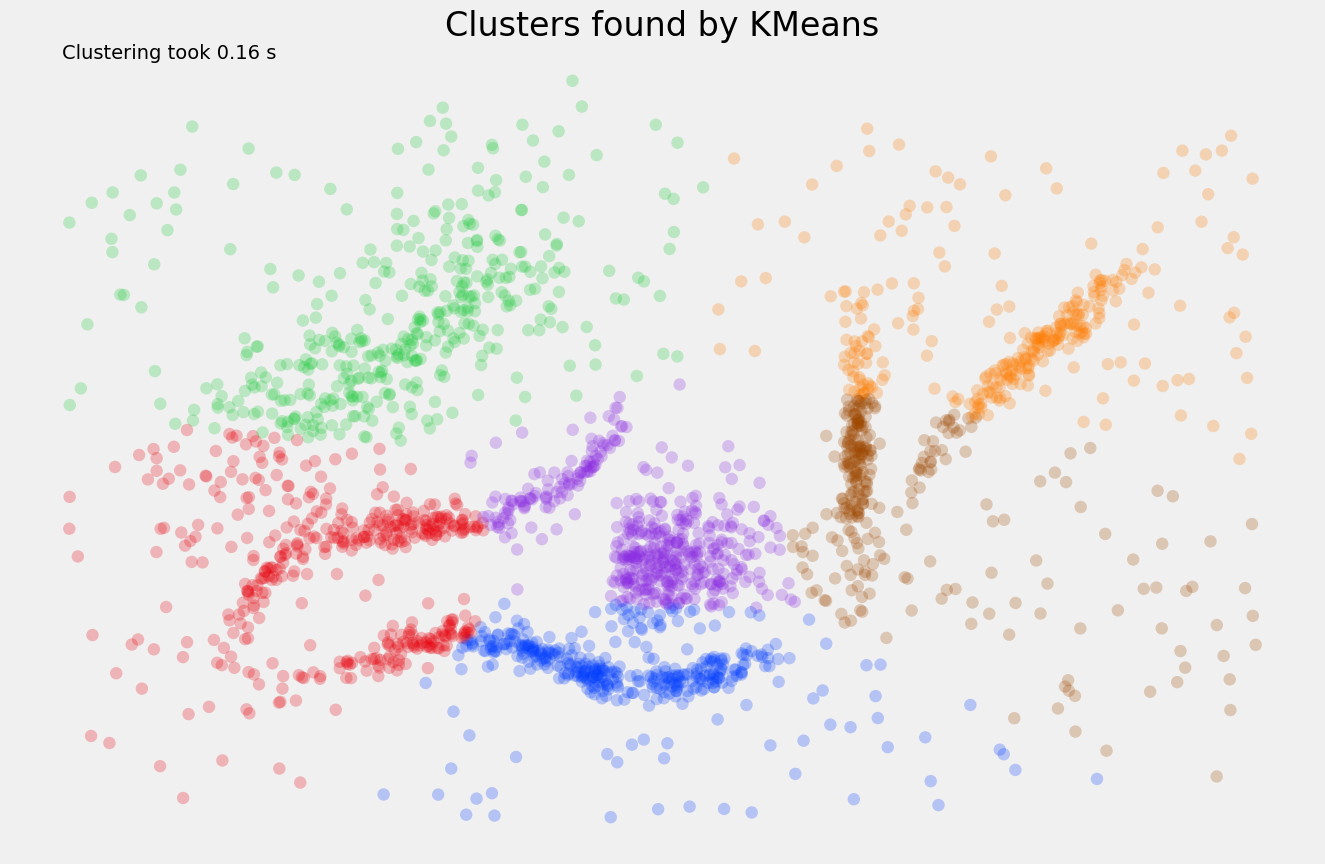

In [8]:
plot_clusters(data, KMeans, {'n_clusters':6})

With the limitations of K-Means in mind the result is not surprising. The assumption of perfectly globular clusters means that the real rather elongated clusters have been poorly identified. What is even worse, the noise points get lumped into clusters as well. In some cases, depending on where the cluster center end up, even relatively distant points are still assigned to a cluster. 

To say something positive as well: K-Means was really quick clustering the data. So at least it's a fast no.

If you want to try out how K-Means performs on different data have a look at this [website](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) by Naftali Harris. You can choose from a range of different datasets and also decide if you want to set the centroids manually or assign them randomly.

## Hierarchical Clustering

Another common clustering technique is hierarchical clustering. It is actually a suite of algorithms all based on the same idea of creating clusters by either merging or splitting them successively. As K-Means the concept behind these algorithms is easy to understand. There are two different approaches: 


#### 1. Divisive clustering

In this method we assign all our observations to a single cluster and then partition the cluster into the two least similar clusters. Then we proceed recursively on each cluster until there is one cluster for each observation.


#### 2. Agglomerative clustering

The main algorithm for hierarchical clustering is the *agglomerative* algorithm and it follows a bottom up approach. Each observation starts in it's own cluster. Computing the similarity (e.g. distance) between each cluster the two most similar clusters will be joined. Finally, repeating the steps over and over results in one big cluster and a cluster hierarchy. Once you have a cluster hierarchy you can choose a level or cut (according to some criteria) and take the clusters at that level of the tree. For `sklearn` we usually choose a cut based on a `n_clusters` parameter passed in.

We can influence the merge strategy by changing the linkage criteria (a hyperparamter):

* **Ward**: minimizes the sum of squared differences within all clusters
* **Maximum** or **complete linkage**: minimizes the maximum distance between observations of pairs of clusters
* **Average linkage**: minimizes the average of the distances between all observations of pairs of clusters
* **Single linkage**: minimizes the distance between the closest observations of pairs of clusters 

#### Dendrogram 

Dendrograms are tree diagrams frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering. The clades are arranged according to how similar (or dissimilar) they are. Clades that are close to the same height are similar to each other; clades with different heights are dissimilar — the greater the difference in height, the greater the dissimilarity.

An example involving the famous Iris data set is shown below.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/12/Iris_dendrogram.png height='400px' width = '400px'>

### Pros and Cons

#### Limitations

* It's still assuming all points belong to a cluster so it's susceptible to noise.
* We need to specify how many clusters (`n_cluster`) we expect. For real world data choosing the right number of clusters based on a dendrogram is most of the time impossible. 

#### Advantages

* No globular assumption. Clusters can grow 'following the underlying manifold'.    
* Cluster hierarchy can be visualized using a dendrogram in order to get more information on how clusters are assigned. 
* Performance can be good with the right implementation; the `sklearn` implementation is rather slow, but [fastcluster](https://pypi.python.org/pypi/fastcluster) provides high performance agglomerative clustering (if you should need one).
* Since we have no random initialization it is stable across runs. 


Let's see how `AgglomerativeClustering` performs on our data. We will provide the (correct) number of clusters and choose `ward` as the linkage/merge method. This is a more robust method, which does well in separating clusters if there is noise between clusters, but it does also tend toward more globular clusters.

In [ ]:
plot_clusters(data, AgglomerativeClustering, {'n_clusters':6, 'linkage':'ward'})

This time the algorithm handled the long thin clusters much better than K-Means, but there are still clusters that contain parts of several different natural clusters. Nevertheless, those "mis-clustered" points are fewer. As with K-Means this algorithm did also assign every point to a cluster and couldn't identify the noise.

Similarly to K-Means this algorithm was really fast clustering the data. 

### Dendrogram 

We can plot a dendrogram for our data. The vertical axis of the dendrogram represents the distance or dissimilarity between clusters. Each joining (fusion) of two clusters is represented on the graph by the splitting of a vertical line into two vertical lines. The vertical position of the split, shown by the short horizontal bar, gives the distance (dissimilarity) between the two clusters. 

In [ ]:
# Plotting the dendrogram of our data
plt.figure(figsize=(20, 10))
plt.title('Dendrogram')
plt.ylabel('Dissimilarity')
plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(data, method = 'ward'))
plt.show()

## DBSCAN

DBSCAN is a density based algorithm. It views clusters as areas of high density separated by areas of low density.

It is also the first actual clustering algorithm we've tested so far: it doesn't need to assign every point to a cluster but really extracts the *dense* clusters and leaves the sparse background/noise untouched. K-Means and agglomerative clustering were rather partitioning the data than clustering it. 

Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

The most important hyperparameter we have to specify matching our data is `eps` (epsilon). Without a proper `eps` DBSCAN will most likely produce unsatisfactory results. With `eps` we can change the maximum distance between samples to be considered in the neighborhood of one another. In order to visualize the effects of `eps` on the clustering performance have a look at this [awesome website](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) and try out different values. 


<img src="images/dbscan.png" alt="Drawing" style="width: 500px"/>


### Pros and Cons

#### Limitations

* Clusters with varying density can cause problems.
  

#### Advantages

* Clusters don't need to be globular.
* Noise will not be assigned to a cluster.
* It is also stable across runs and will generate reproducible results. 
* Its very fast and can cluster very large datasets.

Let's check how DBSCAN performs on our data. For the other two clustering algorithms we had to specify the number of cluster before hand. DBSCAN is able to identify the amount of clusters itself, but we need to provide it with values for `eps` and `min_samples`. There is no way to really calculate the right values for those hyperparameters, but there is a method to get an idea about which range for `eps` might be appropriate. So let's check that first.

### Finding an appropriate value for `min_samples` and `eps`

Unfortunately there is no way to automatically determine which value to use for the hyperparameter `min_samples`. Domain knowledge and a good understanding of the data can help you to choose a good starting point. In our example we'll choose 7.

In order to find a suitable value for epsilon we need to calculate the distance from each point to its closest neighbors. We can use sklearn's `NearestNeighbors` with `n_neighbors` set to the value we want to use for `min_samples` (7 in our example). Afterwards we have to sort and plot the distances. An appropriate value for epsilon can be found at the point of maximum curvature. 

If you want to read more about how to estimate the hyperparameters for DBSCAN, this [medium article](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) and the references cited there are a good starting point. 

In [ ]:
# Initialize and fit NearestNeighbors object
neighbors = NearestNeighbors(n_neighbors=7)
neighbors_fitted = neighbors.fit(data)

# Get distance and indices of pairs of points
distances, indices = neighbors_fitted.kneighbors(data)

# Sort distances 
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot distances to determine suitable value for epsilon
plt.plot(distances)
plt.hlines(0.025, 0, 2130, linestyles='--', color='black',linewidth=2)
plt.ylabel("Distance", size=22)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title("Find suitable value for epsilon", size=26)
plt.text(1900, 0.03,"~ 0.025", size=22);

### DBSCAN Performance

Now that we have some values for epsilon and `min_samples`, we can test the performance of DBSCAN on our data. 

In [ ]:
plot_clusters(data, DBSCAN, {'eps':0.025, 'min_samples':7})

This looks pretty decent. The algorithm identified several natural clusters (also the elongated ones) and didn't assign additional noise to those clusters. It didn't perform so well on the rather sparse cluster and defined some tiny additional clusters. That's due to its limited ability to handle variable density clusters. All in all the algorithm is doing a decent job and it is definitely the fastest of the ones we are comparing here.